In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Setup

In [3]:
n = 3000
m = 5*n
X = np.random.randn(n,m)/np.sqrt(2*n)
A = X@X.T
lam = np.linalg.eigvalsh(A)

b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)

In [4]:
a = .99*lmax

w = a

# norm to measure function approximation and linear system errors
B = (lam-w)**2#np.ones(n)

kappa_w = np.max(np.abs(lam-w)) / np.min(np.abs(lam-w))

In [5]:
np.count_nonzero(lam>a)

4

In [6]:
K = 200
reorth=True
Q,(a_,b_) = exact_lanczos(lam.astype(np.longdouble),b.astype(np.longdouble),K+1,reorth=reorth)

In [7]:
plot_tol = 1e-14

In [8]:
T = np.zeros((3,K+1))
T[0,1:] = b_
T[1] = a_-w
T[2,:-1] = b_

e1 = np.zeros(K+1)
e1[0] = 1

In [9]:
err_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        err_CG[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_CG[k] < plot_tol:
        break

In [10]:
res_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        r = b - np.linalg.norm(b)*(lam-w)*(Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1]))
        res_CG[k] = np.sqrt( r@r )
    except: pass
    
    if res_CG[k] < plot_tol:
        break

## $f(x) = \operatorname{step}(x-a)$, $\Gamma =$ double circles

In [11]:
def f(x):
    return (np.abs(np.real(x))>a)/x

fAb = f(lam)*b

In [12]:
err_lanczos = np.full(K,np.nan)

for k in range(0,K-1):
    try:
        e = fAb - lanczos_FA(f,Q[:,:k+1],a_[:k+1],b_[:k],normb=np.linalg.norm(b))
        err_lanczos[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_lanczos[k] < plot_tol:
        break

In [13]:
a_priori_bound = np.full(K,np.inf)
a_posteriori_bound = np.full(K,np.inf)

def Gamma1(t):
    radius = lmax-w

    z = radius*(np.exp(1j*t))+lmax
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

def Gamma2(t):
    radius = w-lmin

    z = radius*(np.exp(1j*t))+lmin
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz


for k in range(1,K+1):
    a_priori_bound[k-1] = 2*(get_a_priori_bound(f,Gamma1,[0,np.pi],k,w,lmin,lmax)[0]+\
                             get_a_priori_bound(f,Gamma2,[0,np.pi],k,w,lmin,lmax)[0])
    a_posteriori_bound[k-1] = 2*(get_a_posteriori_bound(f,Gamma1,[0,np.pi],a_[:k],b_[:k-1],w,lmin,lmax)[0]+\
                                 get_a_posteriori_bound(f,Gamma2,[0,np.pi],a_[:k],b_[:k-1],w,lmin,lmax)[0])

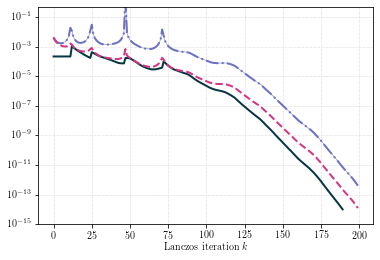

In [14]:
plt.figure(figsize=(6,4))

plt.plot(err_lanczos,linestyle='-',linewidth=2,color='#073642')

#plt.plot(sub_mult_bound,linestyle=(0,(4,2,1,3)),linewidth=1,color='#2aa198')
#plt.plot(triangle_bound,linestyle=(0,(7,5)),linewidth=1,color='#859900')
#plt.plot(full_bound,linestyle='-',linewidth=1,color='#b58900')

plt.plot(a_priori_bound*err_CG,linestyle='-.',linewidth=2,color='#6c71c4')
plt.plot((lmax-a)/a*err_CG,linestyle='-',linewidth=.5,color='#6c71c4')
plt.plot(a_posteriori_bound*err_CG,linestyle='--',linewidth=2,color='#d33682')

#plt.plot(a_priori_bound*res_CG/lmin,linestyle='-.',linewidth=1,color='#6c71c4')
#plt.plot(a_posteriori_bound*res_CG/lmin,linestyle='--',linewidth=1,color='#d33682')


plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',color='#073642',label='$\| f(\mathbf{A})\mathbf{b} - \\textsf{lan}_k(f) \|_{(\\mathbf{{A}}-w\\mathbf{{I}})^2}$'),

#                   Line2D([0],[0],linestyle=(0,(7,5)),linewidth=1,color='#859900',label='triangle inequality'),
#                   Line2D([0],[0],linestyle=(0,(4,2,1,3)),linewidth=1,color='#2aa198',label='sub mult. inequality'),
#                   Line2D([0],[0],linestyle='-',linewidth=1,color='#b58900',label='combined inequality'),

                   Line2D([0],[0],linestyle='--',linewidth=2,color='#d33682',label='$(\\textrm{B1}) \: \| \\textsf{res}_k(w) \|_2$'),
                   Line2D([0],[0],linestyle='-.',linewidth=2,color='#6c71c4',label='$(\\textrm{B2}) \: \| \\textsf{res}_k(w) \|_2$'),
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#6c71c4',label='$(\\textrm{Table 2}) \: \| \\textsf{res}_k(w) \|_2$'),

#                   Line2D([0],[0],linestyle='--',linewidth=1,color='#d33682',label='$(\\textrm{A}) \| \\textsf{reid}_k(w) \|_2/\\lambda_{\\textrm{min}}$'),
#                   Line2D([0],[0],linestyle='-.',linewidth=1,color='#6c71c4',label='$(\\textrm{B}) \| \\textsf{resid}_k(w) \|_2/\\lambda_{\\textrm{min}}$'),
                   
#                   Line2D([0],[0],linestyle=':',linewidth=1,color='#073642',label='$(\\textrm{B2}) \:(\\textrm{CN})$')
                  ]

#plt.plot(a_priori_bound*2*np.max(np.abs(lam-w))*np.linalg.norm(np.sqrt(B)*b)*(( kappa_w - 1 )/( kappa_w + 1 ))**np.arange(K),linestyle=':',linewidth=1,color='#073642')

#plt.legend(handles=legend_elements,loc='lower left')

#for c in range(-12,2,2):
#    plt.plot(10**(c)*(( kappa_w - 1 )/( kappa_w + 1 ))**np.arange(K),linestyle=':',linewidth=1,color='#073642')

plt.ylim(1e-15,5e-1)

plt.grid(True,linestyle=':',linewidth=.5)


#plt.title('$(\\mathbf{{A}}-w\\mathbf{{I}})^2$-norm error bounds: $f(x) = \\mathrm{step}(x-a)/x$,')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/pcr_AwInorm.pdf',bbox_inches='tight')